#Necessary Downloads

In [1]:
!wget https://www.statmt.org/europarl/v7/ro-en.tgz
!tar -xf ro-en.tgz
!pip install transformers
!pip install SentencePiece
!pip install nltk bert-score

--2023-12-02 22:41:10--  https://www.statmt.org/europarl/v7/ro-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.32.28
Connecting to www.statmt.org (www.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38180223 (36M) [application/x-gzip]
Saving to: ‘ro-en.tgz’

ro-en.tgz           100%[===================>]  36.41M  10.5MB/s    in 3.5s    

2023-12-02 22:41:14 (10.5 MB/s) - ‘ro-en.tgz’ saved [38180223/38180223]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


#Imports

In [2]:
import re
import string
import pickle
import pandas as pd
import random
import numpy as np
import torch
import unicodedata
import torch.nn as nn
import torchtext
import nltk
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
from unicodedata import normalize
from pickle import dump
from __future__ import unicode_literals, print_function, division
from io import open
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.utils.data import Dataset, DataLoader
from torch import optim
from transformers import MarianMTModel, MarianTokenizer
from torchtext.data import get_tokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchtext.data.metrics import bleu_score

#Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


#Preprocessing

In [5]:
def readFile(fileName):
    with open(fileName, mode='rt', encoding='utf-8') as file:
        return file.read()

def processSentences(text):
    sentences = text.strip().split('\n')
    regexStatement = re.compile('[^%s]' % re.escape(string.printable))
    translationTable = str.maketrans('', '', string.punctuation)

    filteredSentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translationTable) for word in line.split()]
        words = [regexStatement.sub('', word) for word in words if word.isalpha()]
        filteredSentences.append(' '.join(words))

    return filteredSentences

def saveProcessedSentences(filteredSentences, outputFilename):
    with open(outputFilename, 'wb') as file:
        dump(filteredSentences, file)

def processInputText(fileName, outputFilename):
    text = readFile(fileName)
    filteredSentences = processSentences(text)
    saveProcessedSentences(filteredSentences, outputFilename)
    return filteredSentences

filteredSentences1 = processInputText('europarl-v7.ro-en.en', 'english.pkl')
print("Saved english sentences to english.pkl file")

filteredSentences2 = processInputText('europarl-v7.ro-en.ro', 'romanian.pkl')
print("Saved romanian sentences to romanian.pkl file")

Saved english sentences to english.pkl file
Saved romanian sentences to romanian.pkl file


In [6]:
def loadVocabulary(englishFilename, romanianFilename):
    with open(englishFilename, 'rb') as f:
        englishVocabulary = pickle.load(f)
    with open(romanianFilename, 'rb') as f:
        romanianVocabulary = pickle.load(f)

    data = pd.DataFrame({
        'English': englishVocabulary,
        'Romanian': romanianVocabulary
    })

    return englishVocabulary, romanianVocabulary, data

englishVocabulary, romanianVocabulary, vocabularyData = loadVocabulary('english.pkl', 'romanian.pkl')

def loadSentences(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

def createSubset(sentences, size):
    return sentences[:size]

expectedSentences = loadSentences('english.pkl')
inputSentences = loadSentences('romanian.pkl')

subsetSize = 100000
inputSentencesSubset = createSubset(inputSentences, subsetSize)
expectedSentencesSubset = createSubset(expectedSentences, subsetSize)

In [7]:
sentencePairs = list(zip(inputSentencesSubset, expectedSentencesSubset))
trainingSentences, validationSentences = train_test_split(sentencePairs, test_size=0.20, random_state=42)
trainRomanianVocabulary, trainEnglishVocabulary= zip(*trainingSentences)
valRomanianVocabulary, valEnglishVocabulary= zip(*validationSentences)

#Model Setup

In [8]:
modelName = 'Helsinki-NLP/opus-mt-en-ro'
tokenizer = MarianTokenizer.from_pretrained(modelName)
model = MarianMTModel.from_pretrained(modelName)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/817k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, tokenizer, inputSentences, expectedSentences, max_length=512):
        self.tokenizer = tokenizer
        self.inputSentences = inputSentences
        self.expectedSentences = expectedSentences
        self.max_length = max_length

    def __len__(self):
        return len(self.inputSentences)

    def __getitem__(self, index):
        inputSentence = self.inputSentences[index]
        expectedSentence = self.expectedSentences[index]

        tokenizedInput = self.tokenizer(
            inputSentence, max_length=self.max_length, padding='max_length', truncation=True
        )
        tokenizedTarget = self.tokenizer(
            expectedSentence, max_length=self.max_length, padding='max_length', truncation=True
        )

        inputIDs = tokenizedInput['input_ids']
        expectedIDs = tokenizedTarget['input_ids']

        return torch.tensor(inputIDs), torch.tensor(expectedIDs)

In [10]:
trainingDataset = TranslationDataset(tokenizer, trainRomanianVocabulary, trainEnglishVocabulary)
validationDataset = TranslationDataset(tokenizer, valRomanianVocabulary, valEnglishVocabulary)
trainingDataloader = DataLoader(trainingDataset, batch_size=8, shuffle=True)
validationDataloader = DataLoader(validationDataset, batch_size=8, shuffle=True)

#Training and Validation

In [11]:
def train(model, trainingDataloader, validationDataloader, optimizer, device):
    model.train()
    trainLoss = 0
    for inputIDs, expectedIDs in tqdm(trainingDataloader):
        inputIDs, expectedIDs = inputIDs.to(device), expectedIDs.to(device)

        outputs = model(input_ids=inputIDs, labels=expectedIDs)
        loss = outputs.loss
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    valLoss = 0
    with torch.no_grad():
        for inputIDs, expectedIDs in validationDataloader:
            inputIDs, expectedIDs = inputIDs.to(device), expectedIDs.to(device)
            outputs = model(input_ids=inputIDs, labels=expectedIDs)
            valLoss += outputs.loss.item()

    return trainLoss / len(trainingDataloader), valLoss / len(validationDataloader)

plotTrainingLosses = []
plotValidationLosses = []
optimizer = AdamW(model.parameters(), lr=5e-5)
numberOfEpochs = 3

for epoch in range(numberOfEpochs):
    plotTrainingLoss, plotValidationLoss = train(model, trainingDataloader, validationDataloader, optimizer, device)
    plotTrainingLosses.append(plotTrainingLoss)
    plotValidationLosses.append(plotValidationLoss)
    print(f"Epoch {epoch+1}/{numberOfEpochs}, Training Loss: {plotTrainingLoss}, Validation Loss : {plotValidationLoss}")

100%|██████████| 10000/10000 [2:05:22<00:00,  1.33it/s]


Epoch 1/3, Training Loss: 0.1385088225413114, Validation Loss : 0.0903583845898509


100%|██████████| 10000/10000 [2:05:13<00:00,  1.33it/s]


Epoch 2/3, Training Loss: 0.08370538710840046, Validation Loss : 0.07896118167564273


100%|██████████| 10000/10000 [2:05:13<00:00,  1.33it/s]


Epoch 3/3, Training Loss: 0.07042492826990783, Validation Loss : 0.07357742661684752


#Plotting Losses

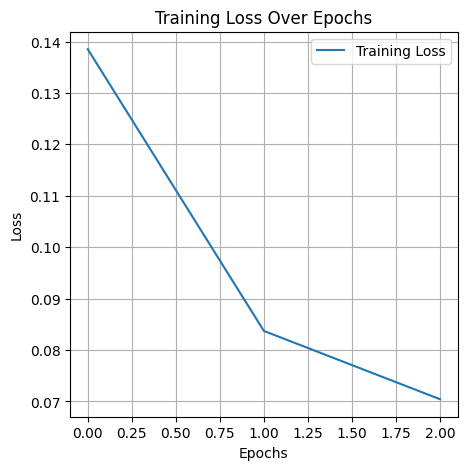

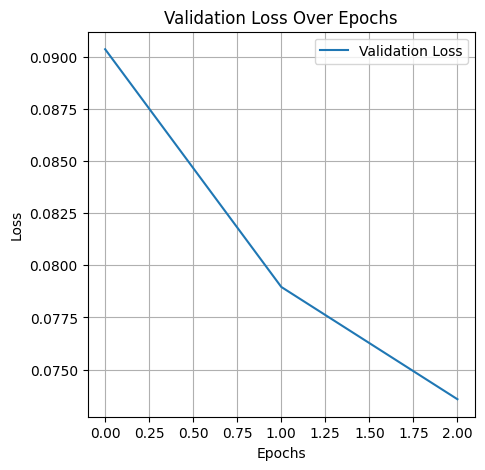

In [12]:
def showTrainingPlot(plotLosses):
    plt.figure(figsize=(5, 5))
    plt.plot(plotLosses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def showValidationPlot(plotLosses):
    plt.figure(figsize=(5, 5))
    plt.plot(plotLosses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

showTrainingPlot(plotTrainingLosses)
showValidationPlot(plotValidationLosses)

#Saving Model

In [13]:
torch.save(model.state_dict(), 'marianMT.pth')
with open('marianMT.pkl', 'wb') as file:
    pickle.dump(model, file)

#Evaluation on Random Sentences

In [14]:
def evaluationOnRandomSamples(model, dataloader, tokenizer, device, numberOfSamples=5):
    model.eval()
    sampleCount = 0

    for batch in random.sample(list(dataloader), len(dataloader)):
        if sampleCount >= numberOfSamples:
            break

        inputIDs, targetIDs = batch
        inputIDs, targetIDs = inputIDs.to(device), targetIDs.to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=inputIDs)

        for i in range(inputIDs.size(0)):
            if sampleCount >= numberOfSamples:
                return

            decodedInputSentences = tokenizer.decode(inputIDs[i], skip_special_tokens=True, truncation=True)
            decodedExpectedSentences = tokenizer.decode(targetIDs[i], skip_special_tokens=True, truncation=True)
            decodedPredictedSentences = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            print(f"Romanian: {decodedInputSentences}\nEnglish (Target): {decodedExpectedSentences}\nEnglish (Predicted): {decodedPredictedSentences}\n")
            sampleCount += 1

evaluationOnRandomSamples(model, validationDataloader, tokenizer, device)

Romanian: in primul rand dupa parerea mea punerea in aplicare a prelevarii suplimentare in momentul de fata ar fi nepotrivita
English (Target): firstly in my view the implementation of the super levy at this time would be inappropriate
English (Predicted): first of all in my opinion the implementation of the further takeover at the moment would be inadequate

Romanian: rapport reimer boge
English (Target): report boge
English (Predicted): report reimer boge

Romanian: in unele dintre domeniile pe care eu le consider a fi cheie raportul propune criterii de selectie a acestor proiecte
English (Target): in some of what i believe are key areas the report proposes criteria for selecting these projects
English (Predicted): in some of the areas that i consider to be key the report proposes criteria for selecting these projects

Romanian: in scris nici utilitatea nici oportunitatea masurilor pentru sanctionarea celor care angajeaza imigranti ilegali nu pot fi puse la indoiala
English (Target):

#Scores Evaluation and Random Testing

In [15]:
nltk.download('wordnet')
def translationMetricsEvaluation(model, dataloader, tokenizer, device):

    model.eval()
    expectedSentencesArray = []
    targetSentencesArray = []

    for batch in dataloader:
        inputIDs, expected_ids = batch
        inputIDs = inputIDs.to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=inputIDs)

        for i in range(inputIDs.size(0)):
            decodedExpected = tokenizer.decode(expected_ids[i], skip_special_tokens=True, truncation=True)
            decodedTarget = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            if decodedExpected and decodedTarget:
                expectedSentencesArray.append([decodedExpected.split()])
                targetSentencesArray.append(decodedTarget.split())

    bleuScore = corpus_bleu(expectedSentencesArray, targetSentencesArray)

    meteorScores = [meteor_score(esa, tsa) for esa, tsa in zip(expectedSentencesArray, targetSentencesArray)]
    averageMeteorScores = sum(meteorScores) / len(meteorScores)

    esas = [' '.join(esa[0]) for esa in expectedSentencesArray]
    tsas = [' '.join(tsa) for tsa in targetSentencesArray]
    P, R, F1 = bert_score(tsas, esas, lang="en", verbose=True)

    F1 = F1.mean().item()
    Precision = P.mean().item()
    Recall = R.mean().item()

    return bleuScore, averageMeteorScores, F1, Precision, Recall

bleuScore, meteorScore, F1Score, Precision, Recall = translationMetricsEvaluation(model, validationDataloader, tokenizer, device)

print(f"BLEU Score: {(bleuScore * 100):.4f}")
print(f"METEOR Score: {(meteorScore * 100):.4f}")
print(f"F1 Score: {(F1Score* 100):.4f}")
print(f"Precision: {(Precision* 100):.4f}")
print(f"Recall: {(Recall* 100):.4f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/588 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/309 [00:00<?, ?it/s]

done in 189.94 seconds, 103.85 sentences/sec
BLEU Score: 41.2839
METEOR Score: 69.7375
F1 Score: 94.9618
Precision: 94.9758
Recall: 94.9559
